# Session 2 : Supervised learning (1/3)

## Preliminaries

Before using the algorithms on real case datasets, we are going to experiment them on artificially generated datasets. We call these types of datasets **toy datasets**. Use the appropriate magic command to load the script `datasets.py` (it contains functions to generate toy datasets).

In [3]:
%lsmagic

Available line magics:
%alias  %alias_magic  %autoawait  %autocall  %automagic  %autosave  %bookmark  %cd  %clear  %cls  %colors  %config  %connect_info  %copy  %ddir  %debug  %dhist  %dirs  %doctest_mode  %echo  %ed  %edit  %env  %gui  %hist  %history  %killbgscripts  %ldir  %less  %load  %load_ext  %loadpy  %logoff  %logon  %logstart  %logstate  %logstop  %ls  %lsmagic  %macro  %magic  %matplotlib  %mkdir  %more  %notebook  %page  %pastebin  %pdb  %pdef  %pdoc  %pfile  %pinfo  %pinfo2  %popd  %pprint  %precision  %prun  %psearch  %psource  %pushd  %pwd  %pycat  %pylab  %qtconsole  %quickref  %recall  %rehashx  %reload_ext  %ren  %rep  %rerun  %reset  %reset_selective  %rmdir  %run  %save  %sc  %set_env  %store  %sx  %system  %tb  %time  %timeit  %unalias  %unload_ext  %who  %who_ls  %whos  %xdel  %xmode

Available cell magics:
%%!  %%HTML  %%SVG  %%bash  %%capture  %%cmd  %%debug  %%file  %%html  %%javascript  %%js  %%latex  %%markdown  %%perl  %%prun  %%pypy  %%python  %%python2  %%

In [7]:
# %load datasets.py
import numpy as np
import pandas as pd
import os
from scipy import signal
from sklearn.datasets import load_boston
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.datasets.samples_generator import make_blobs

def make_forge():
    X, y = make_blobs(centers=2, random_state=4, n_samples=30)
    y[np.array([7, 27])] = 0
    mask = np.ones(len(X), dtype=np.bool)
    mask[np.array([0, 1, 5, 26])] = 0
    X, y = X[mask], y[mask]
    return X, y

def make_wave(n_samples=100):
    rnd = np.random.RandomState(42)
    x = rnd.uniform(-3, 3, size=n_samples)
    y_no_noise = (np.sin(4 * x) + x)
    y = (y_no_noise + rnd.normal(size=len(x))) / 2
    return x.reshape(-1, 1), y

def load_extended_boston():
    boston = load_boston()
    X = boston.data

    X = MinMaxScaler().fit_transform(boston.data)
    X = PolynomialFeatures(degree=2, include_bias=False).fit_transform(X)
    return X, boston.target

def make_signals():
    # fix a random state seed
    rng = np.random.RandomState(42)
    n_samples = 2000
    time = np.linspace(0, 8, n_samples)
    # create three signals
    s1 = np.sin(2 * time)  # Signal 1 : sinusoidal signal
    s2 = np.sign(np.sin(3 * time))  # Signal 2 : square signal
    s3 = signal.sawtooth(2 * np.pi * time)  # Signal 3: saw tooth signal

    # concatenate the signals, add noise
    S = np.c_[s1, s2, s3]
    S += 0.2 * rng.normal(size=S.shape)

    S /= S.std(axis=0)  # Standardize data
    S -= S.min()
    return S

## k-Nearest Neighbors : Classification

### Toy dataset

The dataset we are going to use is a set of points which have either the label `0` or `1`. Use the appropriate command to look at the source code of the function `make_forge()` and use it to create a set of points `X` and a set of labels `y`. How many points have been generated ?

In [29]:
# print source code of make_forge()
??make_forge

In [18]:
# create X and y. How many elements in X ?
X, y = make_forge()

In [19]:
X

array([[ 9.96346605,  4.59676542],
       [11.0329545 , -0.16816717],
       [11.54155807,  5.21116083],
       [ 8.69289001,  1.54322016],
       [ 8.1062269 ,  4.28695977],
       [ 8.30988863,  4.80623966],
       [11.93027136,  4.64866327],
       [ 9.67284681, -0.20283165],
       [ 8.34810316,  5.13415623],
       [ 8.67494727,  4.47573059],
       [ 9.17748385,  5.09283177],
       [10.24028948,  2.45544401],
       [ 8.68937095,  1.48709629],
       [ 8.92229526, -0.63993225],
       [ 9.49123469,  4.33224792],
       [ 9.25694192,  5.13284858],
       [ 7.99815287,  4.8525051 ],
       [ 8.18378052,  1.29564214],
       [ 8.7337095 ,  2.49162431],
       [ 9.32298256,  5.09840649],
       [10.06393839,  0.99078055],
       [ 9.50048972, -0.26430318],
       [ 8.34468785,  1.63824349],
       [ 9.50169345,  1.93824624],
       [ 9.15072323,  5.49832246],
       [11.563957  ,  1.3389402 ]])

In [20]:
y

array([1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0])

In [21]:
len(X)

26

In [22]:
len(y)

26

Now load the `matplotlib` library and use the right method to visualize a set of points on a 2D plan. Look at the documentation and use the approriate argument so that points labeled with `0` have a different color from the points with the label `1`.

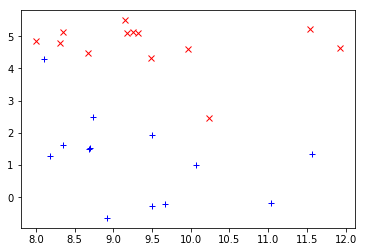

In [36]:
# print the points X with matplotlib
import matplotlib.pyplot as plt
X0 = X[y==0,:]
X1 = X[y==1,:]
plt.plot(X0[:,0], X0[:,1], "+b")
plt.plot(X1[:,0], X1[:,1], "xr")

### Learning a model

As we saw in the course, the first step is to separate our dataset into a training and a test part. Use the function `train_test_split()` library to create four variables :
* points for training
* labels for training
* points for test
* labels for test

Use the parameter `random_state = 0` so the the experiments can be replicated.

In [38]:
from sklearn.model_selection import train_test_split


Then, we can create a KNN model and specify the parameter `k`. Create a model with `k = 3`.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# create model
model = 

Train the model on your training data (with the `.fit()` method) and evaluate its performance (with the `.score()` method) on the test data. How much accuracy do you get ?

It is interesting to see the boundary decision of our model (ie the line indicating where the points are labeled 0 or 1). Run the following piece of code to see it.

In [ ]:
%run plots.py
plot_2d_separator(model, X, y, fill=True, eps=0.5, alpha=0.4)

Create other models with a different value for `k` (use 1, 9 and 15). Train and evaluate each model. Which one is the best one ? 

In [ ]:
# TODO
# models with k = 1, 9, 15

Look at the the decision boundary for each of these models. What can be said about the decision boundary when `k` is low ? When `k` is large ?

In [ ]:
# decision boundary for each models

### Real dataset

Sklearn comes with some real case datasets. One of them is the Wisconsin breast cancer dataset. It contains information (measurements) of breast cancer tumors. Each tumor is either "benign" or "malignant" (so it is a binary classification problem). We are going to use KNN to predict if a tumor is "benign" or "malignant".

In [ ]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()
#print(cancer.DESCR) # uncomment for more information
print(cancer.keys())

This dataset contains 569 data points, each one has 30 attributes (called features). The data can be accessed with `cancer.data` and the labels with `cancer.target`.

In [ ]:
print(cancer.data.shape)
print(cancer.data[0])
print(cancer.target[0])

Separate the points into a training and a test datasets with `random_state = 0`.

Create a KNN classifier with six neighbors and train it with the appropriate data.

The main objective of a classifier model is to be able to predict the label of points we have never seen yet. You can use the `.predict()` method of your classifier and feed it with one or more data points. The result will be the label(s) predicted by your model.

In [ ]:
model.predict([x_test[0]]) # replace model with the name of your model

Now compute the accuracy of your model on the entire test dataset.

## k-Nearest Neighbors : Regression

We can also do regression with the KNN algorithm. Instead of assigning the most frequent label of the k nearest neighbors, we can average the value of the neighbors. Hence we predict a value instead of a class.

Use the `make_wave()` function to create a toy dataset of `40` points for regression.

We can visualize the points with the following piece of code.

In [ ]:
plt.scatter(X, y)
plt.xticks(X, "")

Separate the dataset into a training part and a test part with `random_state = 0`. Then create several models for a KNN regression (at least 3 different models) with different values for the number of neighbors used. Train and evaluate them. What is your best accuracy ?

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

# create train + test data
# ...

# create regression models, train and evaluate
# ...

## Linear models

Linear models are mostly used to do regression (predicting a value given a set of features). You can use a linear model to do classification but we will focus on regression in this course. The predicted value $\hat{y}$ can be written as follows:

\begin{equation*}
\hat{y} = \sum_{k=1}^n w_k \times x_k + b
\end{equation*}

where $x_k$ are the features of the data points, $w_k$ and $b$ are the parameters learned by the linear model.

### Ordinary Least Squares

Ordinary Least Squares is the most classic linear method for regression. This model finds the $w$ and $b$ parameters that minimize the **mean squared error (MSE)** between predictions and the true value for the $m$ points in training dataset.

\begin{equation*}
MSE = {1 \over {m}} \sum_{k=1}^m (\hat{y}-y)^2
\end{equation*}

Generate a toy dataset for regression with the function `make_wave()` composed of `80` data points. Then split this dataset into a training and a test dataset with `random_state = 0`.

Then we can create a linear model and train it on the right dataset.

In [ ]:
from sklearn.linear_model import LinearRegression
# create model and train it
# model = ...

The learned $w$ are in the `coef_` attribute while the learned $b$ are in the `intercept_` attribute. Since our data only has one feature, we only have one $w$.

In [ ]:
print("Learned w:", model.coef_)
print("Learned b:", model.intercept_)

In the same way as before, we can compute the estimate output with the `predict()` method.

In [ ]:
print("Model prediction =", model.predict([x_test[0]]))
print("Hand computed prediction =", model.coef_[0] * x_test[0] + model.intercept_)
print("Correct output =", y_test[0])

### Real dataset

We are going to predict the price of houses given some features. The data come from the housing market in Boston. We have 506 data points, and each one has 104 features.

In [ ]:
X, y = load_extended_boston()
print(X.shape)
print(y.shape)
print(y[:3]) # some house prices

In [ ]:
# separate the data into a training set and a test set with
# random_state = 0. Then train a linear model and predict the
# price of the first house in the test set. Compare it with the 
# actual price of the house.

In [ ]:
# we can also compute the score of the model. Compare
# the score obtained on the training data and the score
# on the test data. 
# Do you thing we are underfitting or overfitting ? Explain why ?
print(model.score(x_train, y_train))
print(model.score(x_test, y_test))

### Regularization

Sometimes, the linear model can overfit. This means that it will be good on the training set, but not on the test set. One way to control overfitting is to add a regularization to our model. We can add a constraint to the objective being minimized by the model.

We will see a L2 normalization that minimizes the norm 2 of the weights $w$ of the model. The name of this new type of model is called **Ridge regression** and it minimizes :

\begin{equation*}
MSE + Regularization = {1 \over {m}} \sum_{k=1}^m (\hat{y}-y)^2 + \lambda \left\lVert w \right\rVert ^2
\end{equation*}

$\lambda$ is a parameter to adjust the effect of regularization.

In [ ]:
from sklearn.linear_model import Ridge

# create a model Ridge, train it on the same training
# set made of the Housing market and evaluate its
# training score and test score. Do you have any improvement ?
# Is it better compared to a model with no regularization ?

In [ ]:
# try different Ridge() models with different values for
# the alpha parameter (read the documentation if necessary).
# Then compute the training and test scores for each model.
# Can you tell what is the influence of alpha on the scores ?